In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, LSTM, TimeDistributed
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from math import sqrt
import matplotlib.pyplot as plt
np.random.seed(7)
tf.random.set_seed(7)

In [ ]:
csv_path = 'train.csv'
train = pd.read_csv(csv_path, parse_dates=['date'])
train = train.query('store == 1 and item ==1').copy()
train = train.sort_values('date')
print(train.head())
print(len(train))

        date  store  item  sales
0 2013-01-01      1     1   13.0
1 2013-01-02      1     1   11.0
2 2013-01-03      1     1   14.0
3 2013-01-04      1     1   13.0
4 2013-01-05      1     1   10.0
1826


In [ ]:
def make_supervised_windows(series: np.ndarray, window: int, lag: int):
    X, y = [], []
    for i in range(window, len(series)-lag):
        X.append(series[i-window:i+1])
        y.append(series[i+lag])
    return np.array(X), np.array(y)

window = 29
lag = 1
X, y =make_supervised_windows(train['sales'].values, window, lag)
print('X', X.shape, 'y', y.shape)

X (1796, 30) y (1796,)


In [ ]:
cut = int(len(X) * .8)
X_train, X_test = X[:cut], X[cut:]
y_train, y_test = y[:cut], y[cut:]

scaler_x = StandardScaler().fit(X_train)
scaler_y = StandardScaler().fit(y_train.reshape(-1, 1))
X_train_s = scaler_x.transform(X_train)
X_test_s = scaler_x.transform(X_test)
y_train_s = scaler_y.transform(y_train.reshape(-1, 1)).ravel()
y_test_s = scaler_y.transform(y_test.reshape(-1, 1)).ravel()

print('X_train_s', X_train_s.shape, 'y_train_s', y_train_s.shape)

X_train_3d = X_train_s.reshape((len(X_train_s), window+1, 1))
X_test_3d = X_test_s.reshape((len(X_test_s), window+1, 1))

print('Train 3d:', X_train_3d.shape, 'Test_3d', X_test_3d.shape)

X_train_s (1436, 30) y_train_s (1436,)
Train 3d: (1436, 30, 1) Test_3d (360, 30, 1)


In [ ]:
from keras.models import Sequential
from keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense

model_cnn = Sequential([
    Input(shape=(window+1, 1)),
    Conv1D(filters=32, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(1)
])

model_cnn.compile(optimizer='adam', loss='mse')
model_cnn.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 28, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 14, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 448)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │        14,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,529 (56.75 KB)

 Trainable params: 14,529 (56.75 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_cnn = model_cnn.fit(X_train_3d, y_train_s, epochs=50, batch_size=32, verbose=1)

Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.6348
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5377
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5124
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4985
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4840
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4748
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4631
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4530
Epoch 9/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4426
Epoch 10/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4348
Epoch 11/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4259
Epoch 12/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4180
Epoch 13/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4079
Epoch 14/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3997
Epoch 15/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3873
Epoch 16/50
45/45 ━

In [ ]:
pred_cnn_s = model_cnn.predict(X_test_3d).ravel()
pred_cnn = scaler_y.inverse_transform(pred_cnn_s.reshape(-1, 1)).ravel()
print('RMSE:', sqrt(mean_squared_error(y_test, pred_cnn)))

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
RMSE: 6.2625568332180075


In [ ]:
from keras.layers import Input, LSTM, Dense
from keras.models import Sequential

model_lstm = Sequential([
    Input(shape=(window+1, 1)),
    LSTM(32, activation='tanh'),
    Dense(1)
])

model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 32)             │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,385 (17.13 KB)

 Trainable params: 4,385 (17.13 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_lstm = model_lstm.fit(X_train_3d, y_train_s, epochs=50, batch_size=32, verbose=1)

Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.8220
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.6152
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.6113
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.6092
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.6076
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.6062
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.6051
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.6040
Epoch 9/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.6031
Epoch 10/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.6023
Epoch 11/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.6015
Epoch 12/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.6007
Epoch 13/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.6000
Epoch 14/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.5992
Epoch 15/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.5985
Epoc

In [ ]:
pred_lstm_s = model_lstm.predict(X_test_3d).ravel()
pred_lstm = scaler_y.inverse_transform(pred_lstm_s.reshape(-1,1)).ravel()
print('RMSE:', sqrt(mean_squared_error(y_test, pred_lstm)))

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
RMSE: 5.262892678725943


In [ ]:
from keras.layers import Input, TimeDistributed, Conv1D, MaxPooling1D, Flatten, LSTM, Dense
from keras.models import Sequential
subseq = 5
assert (window+1) % subseq == 0, "window must be divisible by subseq"
steps_per_subseq = (window+1)//subseq

Xtr4 = X_train_3d.reshape((len(X_train_3d), subseq, steps_per_subseq, 1))
Xva4 = X_test_3d.reshape((len(X_test_3d), subseq, steps_per_subseq, 1))
model_cnn_lstm = Sequential([
    Input(shape=(subseq, steps_per_subseq, 1)),
    TimeDistributed(Conv1D(filters=32, kernel_size=3, activation='relu')),
    TimeDistributed(MaxPooling1D(2)),
    TimeDistributed(Flatten()),
    LSTM(32, activation='tanh'),
    Dense(1)
])

model_cnn_lstm.compile(optimizer='adam', loss='mse')
model_cnn_lstm.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 5, 4, 32)       │           128 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 5, 2, 32)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 5, 64)          │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,577 (49.13 KB)

 Trainable params: 12,577 (49.13 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_cnn_lstm = model_cnn_lstm.fit(Xtr4, y_train_s, epochs=50, batch_size=32, verbose=1)

Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.7782
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.6047
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.5836
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.5719
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.5641
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.5574
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.5518
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.5466
Epoch 9/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.5418
Epoch 10/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.5372
Epoch 11/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.5329
Epoch 12/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.5290
Epoch 13/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.5255
Epoch 14/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.5223
Epoch 15/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5193
Epoch

In [ ]:
pred_cnn_lstm_s = model_cnn_lstm.predict(Xva4).ravel()
pred_cnn_lstm = scaler_y.inverse_transform(pred_cnn_lstm_s.reshape(-1, 1)).ravel()
print('RMSE:', sqrt(mean_squared_error(y_test, pred_cnn_lstm)))

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
RMSE: 5.326215994813846


In [ ]:
import matplotlib.pyplot as plt
rmse_cnn = sqrt(mean_squared_error(y_test, pred_cnn))
rmse_lstm = sqrt(mean_squared_error(y_test, pred_lstm))
rmse_cnn_lstm = sqrt(mean_squared_error(y_test, pred_cnn_lstm))
print('Summary RMSE')
print('CNN', rmse_cnn)
print('LSTM', rmse_lstm)
print('CNN + LSTM', rmse_cnn_lstm)

Summary RMSE
CNN 6.2625568332180075
LSTM 5.262892678725943
CNN + LSTM 5.326215994813846


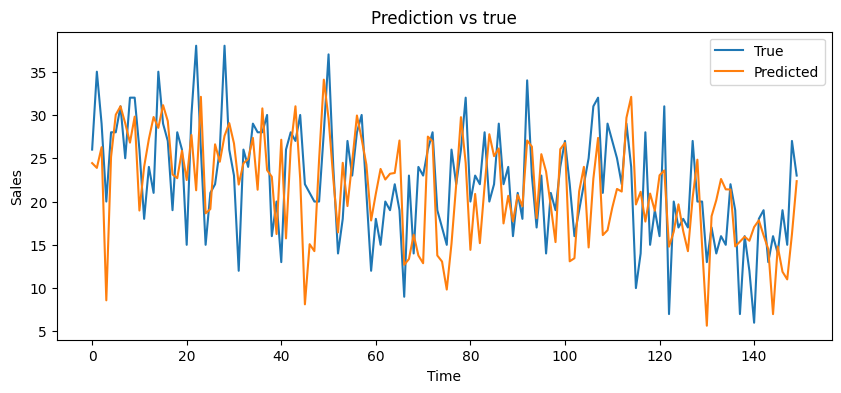

In [ ]:
y_true = y_test
y_pred = pred_cnn

k = 150 if len(y_true) > 150 else len(y_true)
plt.figure(figsize=(10,4))
plt.plot(y_true[-k:], label='True')
plt.plot(y_pred[-k:], label='Predicted')
plt.title('Prediction vs true')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend()
plt.show()